In [ ]:
import os
os.environ['HF_HOME'] = '/scratch/ss13750/huggingface'
os.environ['HF_HUB_CACHE'] = '/scratch/ss13750/huggingface'
os.environ["HF_TOKEN"] = ""

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
import nnsight
from nnsight import LanguageModel
from nnsight import CONFIG
import torch
import torch.nn.functional as F
import random
import datasets
from typing import Optional, List, Dict, Tuple
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from IPython.display import clear_output
try:
    import google.colab
    is_colab = True
except ImportError:
    is_colab = False

if is_colab:
    !pip install --no-deps nnsight
    !pip install msgspec python-socketio[client]
    !pip install -U datasets

clear_output()

In [5]:
# Model configuration. For loading a model not supported by NDIF, set REMOTE to False.
REMOTE = False # set to True to use the NDIF hosted model
# model_name = "meta-llama/Meta-Llama-3.1-8B-Instruct"
# model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen2.5-0.5B-Instruct"
# model_name="Qwen/Qwen2.5-3B"
# model_name="Qwen/Qwen2.5-7B-Instruct"
# model_name = "/scratch/ss13750/nnsight/out_models/Qwen_Qwen2_5-7B-Instruct__4-5-11-12-17-20-24"
# model_name = "/scratch/ss13750/rl/outputs/gkd_qwen7b_dolci_v1/checkpoint-6000"
# model_name = "allenai/OLMo-2-0425-1B"
# model_name = "allenai/OLMo-2-1124-7B-SFT"
# model_name="mistralai/Mistral-7B-Instruct-v0.3"
# model_name = "deepseek-ai/deepseek-llm-7b-chat"
# model_name = "/scratch/ss13750/nnsight/out_models/meta-llama_Llama-3_1-8B-Instruct__22-23-24-25-26-27-28-29"
# model_name = "/scratch/ss13750/nnsight/out_models/merged_llama_8cossim_checkpoint9000"
model_name="google/gemma-2-2b-it"

N_EXAMPLES = 1000 # Number of examples for the future effect tests.
if REMOTE:
    if is_colab:
        # include your HuggingFace Token and NNsight API key on Colab secrets
        from google.colab import userdata
        NDIF_API = userdata.get('NDIF_API')
        HF_TOKEN = userdata.get('HF_TOKEN')

        CONFIG.set_default_api_key(NDIF_API)
        !huggingface-cli login -token HF_TOKEN
    else:
        nnsight.CONFIG.API.APIKEY = os.environ["NDIF_API"]

clear_output()

In [6]:
def load_model():
    if not REMOTE:
        from transformers import BitsAndBytesConfig
    #     bnb_config = BitsAndBytesConfig(
    #         load_in_8bit=True,
    #         bnb_8bit_compute_dtype=torch.bfloat16
    #     )
        llm = LanguageModel(model_name, device_map="auto", 
    #                         quantization_config=bnb_config, 
                            torch_dtype=torch.bfloat16)
    else:
        llm = LanguageModel(model_name)
    
    llm.eval()
    return llm

llm = load_model()
print(llm)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemm

In [7]:
llm.device

device(type='meta')

In [8]:
# Dataset for the GSM8K benchmark.
class GSM8K:
    def __init__(self):
        self.dataset = datasets.load_dataset("openai/gsm8k", "main", split="test")

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        # Format GSM8K example according to the LM evaluation harness.
        question = example["question"]
        answer = example["answer"].split("####")
        assert len(answer) == 2
        res = f"Given the following problem, reason and give a final answer to the problem.\nProblem: {question}\nYour response should end with \"The final answer is [answer]\" where [answer] is the response to the problem.\n"
        return f"{res}\n{answer[0]}The final answer is {answer[1].strip()}"

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [9]:
# Dataset for the GSM8K benchmark.
class SlimPajama:
    def __init__(self):
        self.dataset = datasets.load_dataset("DKYoon/SlimPajama-6B", split="validation", streaming=True)

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        return example['text']

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [10]:
# Dataset for the GSM8K benchmark.
class C4:
    def __init__(self):
        self.dataset = datasets.load_dataset("allenai/c4", "en", split="validation", streaming=True)

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        return example['text']

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [11]:
# Dataset for the GSM8K benchmark.
class Omega:
    def __init__(self):
        self.dataset = datasets.load_dataset("allenai/omega-explorative", "logic_gridworld_knight_move", split="train")

    @staticmethod
    def format_example(example: Dict[str, str]) -> str:
        # Format GSM8K example according to the LM evaluation harness.
        question = example["messages"][0]["content"]
        answer = example["ground_truth"]

        res = f"{question}"
        return f"{res}\nThe final answer is {answer}"

    def __iter__(self):
        for example in self.dataset:
            yield self.format_example(example)

In [12]:
def tokenize(llm: LanguageModel, prompt: str, add_special_tokens: bool = True) -> List[str]:
    # Tokenize a prompt and return the tokens as a list of strings.
    tokens = llm.tokenizer(prompt, add_special_tokens=add_special_tokens)["input_ids"]
    token_str = [s.replace("Ġ","_") for s in llm.tokenizer.convert_ids_to_tokens(tokens)]
    return token_str

In [13]:
prompts = []
dataset = GSM8K

for i, prompt in enumerate(dataset()):
    if i >= 100:
        break
    prompts.append(prompt)

In [14]:
# # out_path = ("../aadim/Ablation/results/qwen-1.5-instruct-math-20250730_135309")
# out_path = "../aadim/Ablation/results/qwen-base-logicgridknight-20250814_093607"
# with open(out_path + "/baseline.json", "r") as f:
#     data = json.load(f)
# baseline_df = pd.DataFrame(data['results'])

In [15]:
# temp = baseline_df.sample(100, random_state=123)
# prompts = (temp['prompt'] + temp['model_response']).to_list()

In [16]:
# prompts = []
# for i, prompt in enumerate(SlimPajama()):
#     if i >= 100:
#         break
#     prompts.append(prompt)

In [17]:
sum([len(llm.tokenizer(prompt)['input_ids']) for prompt in prompts])

22660

In [18]:
# target_layers = [22]
# noise_std = 0.01

# model_edited = edit_model(llm, target_layers, noise_std)

In [22]:
import torch.nn.functional as F
import gc

def get_layer_input_tensor(layer_inputs):
    """Extract the actual input tensor from potentially nested structure"""
    current = layer_inputs
    
    # Keep unpacking tuples until we get a tensor
    while isinstance(current, tuple):
        current = current[0]
    
    return current

def analyze_cos(llm, prompts):
    all_cosines = []
    
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            for j, prompt in tqdm(enumerate(prompts), total=len(prompts)):
                with llm.trace(prompt):
                    cosine_similarities = []
                    try:
                        for i, layer in enumerate(llm.model.layers):
                            #input_ids = input_ids.to(llm.device)
                            # layer.inputs gives back a tuple with two elements
                            # first entry is another tuple with one element which has the inputs
                            # in shape of 1x tokens x hidden dim
                            # second entry is dict with keys: ['attention_mask', 'position_ids', 'past_key_value', 'use_cache', 'cache_position', 'position_embeddings']
                            # layer.output is simply a tensor with shape 1x tokens x hidden dim
                            
                            
                            layer_inputs = get_layer_input_tensor(layer.inputs)  # Save the input
                            layer_output = layer.output       # Save the original output
                            
                            # Make sure layer_output is also a tensor (in case it's wrapped)
                            if isinstance(layer_output, tuple):
                                layer_output = get_layer_input_tensor(layer_output)

                            # Calculate cosine similarity between input and output
                            # layer_inputs and layer_output shape: (1, seq_len, hidden_dim)
                            input_flat = layer_inputs.view(-1, layer_inputs.size(-1))    # (seq_len, hidden_dim)
                            output_flat = layer_output.view(-1, layer_output.size(-1))   # (seq_len, hidden_dim)

                            # Calculate cosine similarity for each token position
                            cos_sim = F.cosine_similarity(input_flat.detach().cpu().float(), output_flat.detach().cpu().float(), dim=1)  # (seq_len,)
                            avg_cosine_similarity = cos_sim.mean().item().save()  # Average across all tokens
                            cosine_similarities.append(avg_cosine_similarity)
                            
                        all_cosines.append(cosine_similarities)
                        
                    except Exception as e:
                        print(f"\nError in layer {i}, prompt {j}: {e}")
                        # Emergency cleanup
                        torch.cuda.empty_cache()
                        gc.collect()
                        #continue
                    
                    finally:
                        # Periodic memory cleanup
                        if j % 3 == 0:  # Every 3 prompts
                            torch.cuda.empty_cache()
                            gc.collect()
                    
    return all_cosines

In [23]:
torch.__version__

'2.4.0+cu121'

In [24]:
data = analyze_cos(llm, prompts[:1000])

100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


In [25]:
cossims = np.array(data).mean(axis=0)

In [26]:
import matplotlib.pyplot as plt

def lineplot_with_annotations(data, title="Line Plot", xlabel="Index", ylabel="Value", 
                              annotate_format="{:.2f}", figsize=(8,5)):
    """
    Creates a line plot with annotated data points.
    
    Parameters:
    - data: A list or 1D numpy array of values.
    - title, xlabel, ylabel: Plot labels.
    - annotate_format: Format string for annotations (e.g., "{:.2f}" or "{}").
    - figsize: Figure size (width, height).
    """
    x = list(range(len(data)))
    y = data

    plt.figure(figsize=figsize)
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=6)
    
    # Annotate each point
    for xi, yi in zip(x, y):
        plt.text(xi, yi + 0.02, annotate_format.format(yi),
                 ha='center', va='bottom', fontsize=6,
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", lw=0.5, alpha=0.8))
    
    plt.title(title, fontsize=14, weight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


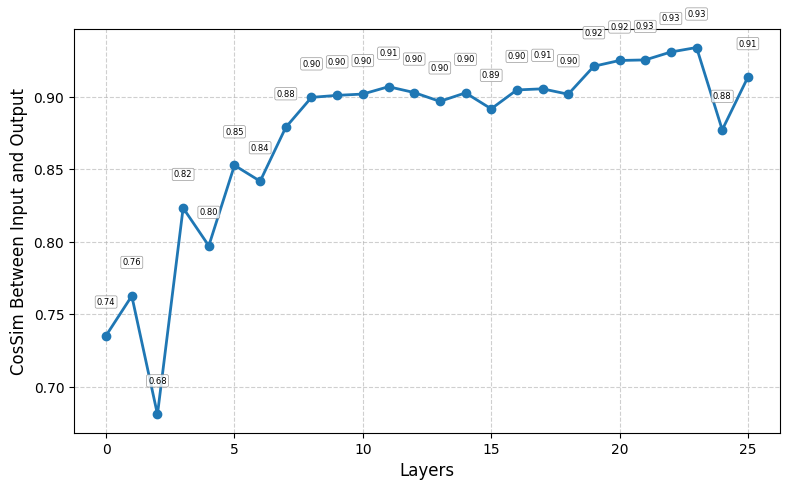

In [27]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

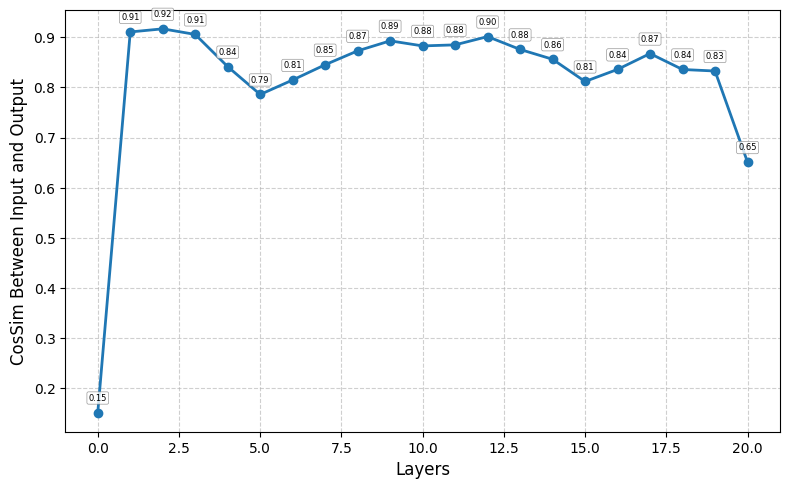

In [24]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

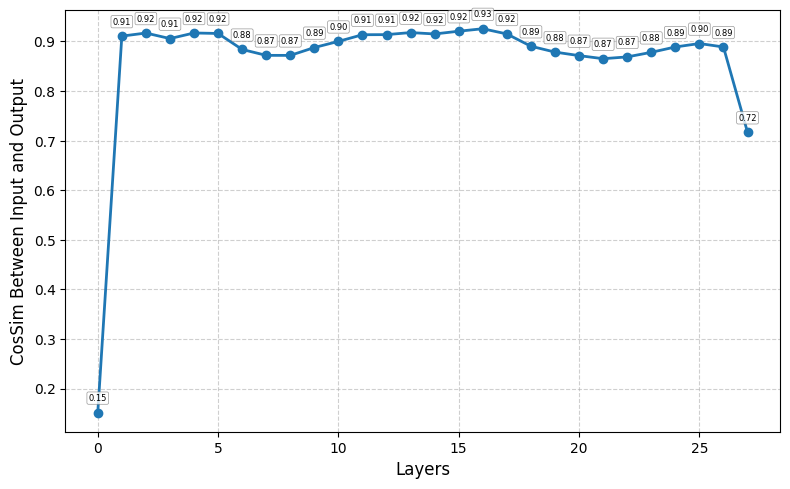

In [23]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

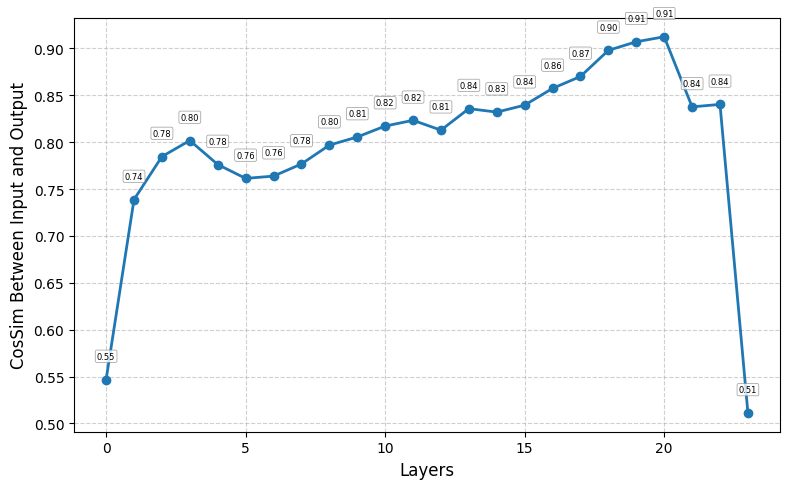

In [24]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

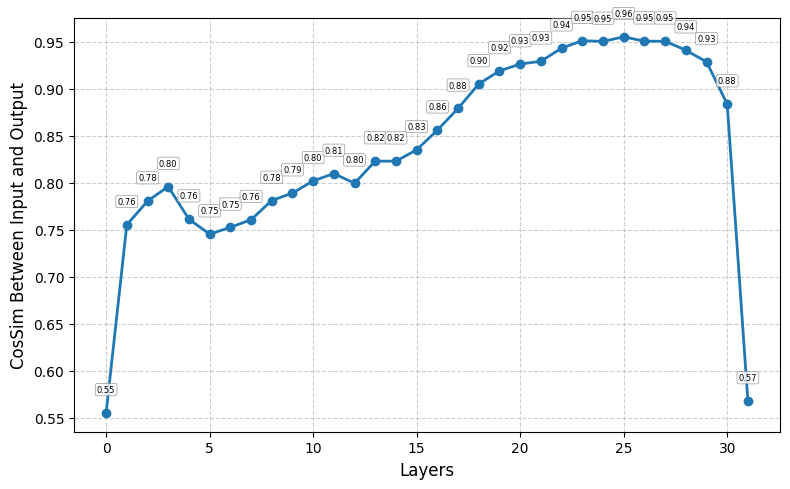

In [24]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

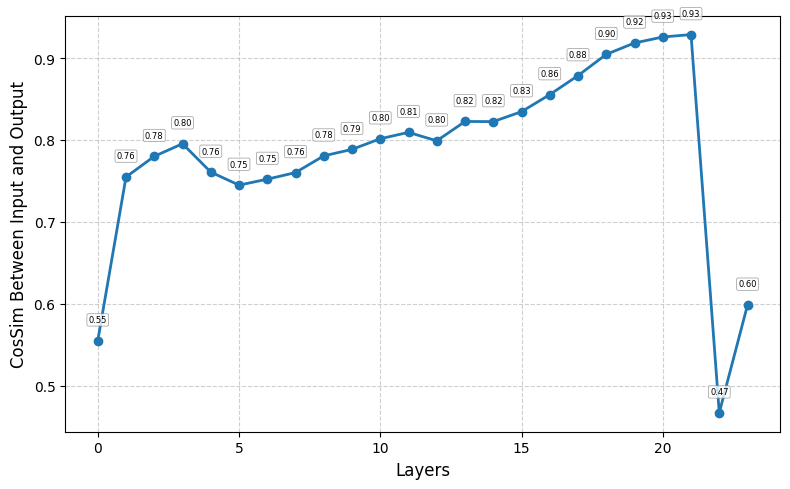

In [24]:
lineplot_with_annotations(cossims, xlabel="Layers", ylabel="CosSim Between Input and Output", title=None)

In [28]:
# Save
np.save("gemma2b-instruct-gsm8k1000-cossims.npy", cossims)

### Perplexity Analysis

In [ ]:
# llm.to(torch.device("cuda"))

In [20]:
import torch.nn.functional as F
import gc

def analyze_perplexity(llm, prompts):
    var = None
    all_perplexities = {}
    all_cosines = {}
    all_diff_cos_sims = {}
    
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            for i, layer in enumerate(llm.model.layers):
                print("Processing Layer", i)
                perplexities = []
                cosine_similarities = []
                diff_cos_sims = []
                
                for j, prompt in tqdm(enumerate(prompts), total=len(prompts)):
                    input_ids = torch.tensor(llm.tokenizer(prompt)['input_ids']).unsqueeze(0).long()
                    
                    try:
                        with llm.trace(prompt):
                            input_ids = input_ids.to(llm.device)
                            # layer.inputs gives back a tuple with two elements
                            # first entry is another tuple with one element which has the inputs
                            # in shape of 1x tokens x hidden dim
                            # second entry is dict with keys: ['attention_mask', 'position_ids', 'past_key_value', 'use_cache', 'cache_position', 'position_embeddings']
                            # layer.output is simply a tensor with shape 1x tokens x hidden dim
                            
                            layer_inputs = layer.inputs[0][0]  # Save the input
                            layer_output = layer.output       # Save the original output
                            
                            # Calculate cosine similarity between input and output
                            # layer_inputs and layer_output shape: (1, seq_len, hidden_dim)
                            input_flat = layer_inputs.view(-1, layer_inputs.size(-1))    # (seq_len, hidden_dim)
                            output_flat = layer_output.view(-1, layer_output.size(-1))   # (seq_len, hidden_dim)
                            
                            # Calculate cosine similarity for each token position
                            cos_sim = F.cosine_similarity(input_flat.detach().cpu().float(), output_flat.detach().cpu().float(), dim=1)  # (seq_len,)
                            avg_cosine_similarity = cos_sim.mean().item()  # Average across all tokens
                            cosine_similarities.append(avg_cosine_similarity)
                            
                            layer_diff = (output_flat - input_flat).detach()
                            # Calculate cosine similarity for each token position
                            cos_sim = F.cosine_similarity(layer_diff.detach().cpu().float(), input_flat.detach().cpu().float(), dim=1)  # (seq_len,)
                            avg_cosine_similarity = cos_sim.mean().item()  # Average across all tokens
                            diff_cos_sims.append(avg_cosine_similarity)
                            
                            del input_flat, output_flat, layer_diff
                            
                            
                            layer.output = layer_inputs              # Set output to input (intervention)
                            
                            # Save the model's logit output
                            # llm.output has the model's final outputs which has logits and past_key_values entries
                            # logits is in shape of 1xtokensxvocab
                            logits = llm.output.logits  # Keep on GPU initially
                            
                            # After the trace, calculate perplexity
                            # The targets are the input tokens shifted by one position
                            targets = input_ids[:, 1:]  # Shape: (1, seq_len-1)
                            pred_logits = logits[:, :-1, :]  # Shape: (1, seq_len-1, vocab_size)
                            
                            # Calculate cross-entropy loss directly on GPU to avoid large CPU tensor
                            loss = F.cross_entropy(
                                pred_logits.view(-1, pred_logits.size(-1)),
                                targets.view(-1)
                            )
                            
                            # Convert to perplexity - only move the scalar to CPU
                            perplexity = torch.exp(loss).detach().cpu().item()
                            perplexities.append(perplexity)
                            
                            # Explicit cleanup of large tensors
                            del logits, pred_logits, targets, loss
                            del layer_inputs, layer_output  # Clean up layer tensors too
                            
                            #li = layer_inputs
                    
                    except Exception as e:
                        print(f"\nError in layer {i}, prompt {j}: {e}")
                        # Emergency cleanup
                        torch.cuda.empty_cache()
                        gc.collect()
                        continue
                    
                    finally:
                        # Clean up input_ids
                        del input_ids
                        
                        # Periodic memory cleanup
                        if j % 3 == 0:  # Every 3 prompts
                            torch.cuda.empty_cache()
                            gc.collect()
                
                # Store results for this layer
                all_perplexities[f'layer{i}'] = perplexities
                all_cosines[f'layer{i}'] = cosine_similarities
                all_diff_cos_sims[f'layer{i}'] = diff_cos_sims
                
                # Major cleanup after each layer
                torch.cuda.empty_cache()
                gc.collect()
                
                # Memory monitoring
                if torch.cuda.is_available():
                    allocated = torch.cuda.memory_allocated() / 1e9
                    reserved = torch.cuda.memory_reserved() / 1e9
                    print(f" | GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
            
        return all_perplexities, all_cosines, all_diff_cos_sims

In [ ]:
ppl, cosines, diff_input_cosines = analyze_perplexity(llm, prompts[:1000])

Processing Layer 0


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


 | GPU Memory: 15.25GB allocated, 15.28GB reserved
Processing Layer 1


100%|██████████| 1000/1000 [02:35<00:00,  6.44it/s]


 | GPU Memory: 15.25GB allocated, 15.28GB reserved
Processing Layer 2


 29%|██▉       | 290/1000 [00:44<01:34,  7.54it/s]

In [21]:
import json

data = {
    'ppl': ppl,
    'cosines': cosines,
    'diff_input_cosines': diff_input_cosines
}

fname = "mistral_internals.json"
with open(f"./data/{fname}", "w") as f:
    json.dump(data, f, indent=2)

In [ ]:
# Save
np.save("llama8b-instruct-slimpajama1000-cossims.npy", cossims)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_perplexity_and_cosine(ppl_data, cosine_data, diff_input_cosine_data):
    """
    Plot average perplexity and cosine similarities across layers in subplots
    
    Args:
        ppl_data: Dictionary with format {'layer0': [perplexities], 'layer1': [perplexities], ...}
        cosine_data: Dictionary with format {'layer0': [cosine_similarities], 'layer1': [cosine_similarities], ...}
        diff_input_cosine_data: Dictionary with format {'layer0': [diff_input_cosines], 'layer1': [diff_input_cosines], ...}
    """
    # Extract layer names and calculate averages for all metrics
    layers = []
    avg_perplexities = []
    avg_cosines = []
    avg_diff_input_cosines = []
    
    # Sort layers by layer number for proper ordering
    sorted_layers = sorted(ppl_data.keys(), key=lambda x: int(x.replace('layer', '')))
    
    for layer in sorted_layers:
        layers.append(layer)
        avg_perplexities.append(np.mean(ppl_data[layer]))
        avg_cosines.append(np.mean(cosine_data[layer]))
        avg_diff_input_cosines.append(np.mean(diff_input_cosine_data[layer]))
    
    # Create subplots with 1 row, 3 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    x_positions = range(len(layers))
    
    # Plot perplexity on the left
    ax1.plot(x_positions, avg_perplexities, 'b-o', linewidth=2, markersize=6, color='blue')
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('Average Perplexity', fontsize=12)
    ax1.set_title('Average Perplexity Across Model Layers', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    ax1.set_yscale('log')
    
    # Plot input-output cosine similarity in the middle
    ax2.plot(x_positions, avg_cosines, 'r-o', linewidth=2, markersize=6, color='red')
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Average Cosine Similarity', fontsize=12)
    ax2.set_title('Average Input-Output Cosine Similarity', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    
    # Plot difference-input cosine similarity on the right
    ax3.plot(x_positions, avg_diff_input_cosines, 'g-o', linewidth=2, markersize=6, color='green')
    ax3.set_xlabel('Layer', fontsize=12)
    ax3.set_ylabel('Average Cosine Similarity', fontsize=12)
    ax3.set_title('Average Diff-Input Cosine Similarity', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(x_positions)
    ax3.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_perplexity_and_cosine(ppl, cosines, diff_input_cosines)

In [20]:
import torch.nn.functional as F
import gc

def analyze_perplexity_without_intervention(llm, prompts):
    var = None
    all_perplexities = {}
    all_cosines = {}
    all_diff_cos_sims = {}
    
    perplexities = []
    
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            
            for j, prompt in tqdm(enumerate(prompts), total=len(prompts)):
                input_ids = torch.tensor(llm.tokenizer(prompt)['input_ids']).unsqueeze(0).long()
                
                cosine_similarities = []
                diff_cos_sims = []

                with llm.trace(prompt):
                    input_ids = input_ids.to(llm.device)
                    try:
                        # layer.inputs gives back a tuple with two elements
                        # first entry is another tuple with one element which has the inputs
                        # in shape of 1x tokens x hidden dim
                        # second entry is dict with keys: ['attention_mask', 'position_ids', 'past_key_value', 'use_cache', 'cache_position', 'position_embeddings']
                        # layer.output is simply a tensor with shape 1x tokens x hidden dim
                        #for j, layer in enumerate(llm.model.layers):
   
                        # Save the model's logit output
                        # llm.output has the model's final outputs which has logits and past_key_values entries
                        # logits is in shape of 1xtokensxvocab
                        logits = llm.output.logits  # Keep on GPU initially

                        # After the trace, calculate perplexity
                        # The targets are the input tokens shifted by one position
                        targets = input_ids[:, 1:]  # Shape: (1, seq_len-1)
                        pred_logits = logits[:, :-1, :]  # Shape: (1, seq_len-1, vocab_size)

                        # Calculate cross-entropy loss directly on GPU to avoid large CPU tensor
                        loss = F.cross_entropy(
                            pred_logits.view(-1, pred_logits.size(-1)),
                            targets.view(-1)
                        )

                        # Convert to perplexity - only move the scalar to CPU
                        perplexity = torch.exp(loss).detach().cpu().item()
                        perplexities.append(perplexity)

                        # Explicit cleanup of large tensors
                        del logits, pred_logits, targets, loss
                        #del layer_inputs, layer_output  # Clean up layer tensors too

                        #li = layer_inputs

                    except Exception as e:
                        print(f"\nError in layer {i}, prompt {j}: {e}")
                        # Emergency cleanup
                        torch.cuda.empty_cache()
                        gc.collect()

                    finally:
                        # Clean up input_ids
                        del input_ids

                        # Periodic memory cleanup
                        if j % 3 == 0:  # Every 3 prompts
                            torch.cuda.empty_cache()
                            gc.collect()

                    # Store results for this layer
                    
                    #all_cosines[f'layer{i}'] = cosine_similarities
                    #all_diff_cos_sims[f'layer{i}'] = diff_cos_sims

                    # Major cleanup after each layer
                    torch.cuda.empty_cache()
                    gc.collect()

                # Memory monitoring
                if torch.cuda.is_available():
                    allocated = torch.cuda.memory_allocated() / 1e9
                    reserved = torch.cuda.memory_reserved() / 1e9
                    #print(f" | GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
            all_perplexities[f'all'] = perplexities
    return all_perplexities, all_cosines, all_diff_cos_sims

In [21]:
# ppl_all = {}
# counter = 0

# for noise_std in tqdm(np.linspace(0.001, 0.01, 5), desc="Noise std levels"):
#     counter += 1
    
#     ppl_noisy = []
#     print("Analyzing for", noise_std)
    
#     for index in tqdm(range(len(llm.model.layers)), desc="Layer"):
#         llm = load_model()
#         target_layers = [index]
        
#         edit_model(llm, target_layers, noise_std)
#         ppl, cosines, diff_input_cosines = analyze_perplexity_without_inv(llm, prompts[:1])
        
#         llm.clear_edits()
#         #model_edited.clear_edits()
        
#         #del model_edited
#         torch.cuda.empty_cache()
#         gc.collect()

#         #print(ppl)
#         #print(sum(ppl['all']) / len(ppl['all']))
#         ppl_noisy.append(sum(ppl['all']) / len(ppl['all']))
    
#     ppl_all[str(noise_std)] = ppl_noisy

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np

# # # Your data
# # data = {
# #     '0.005': [11.1875, 12.59375, 26.875, 69.5, 463.5, 359.0, 425.0, 580.0, 1188.0, 
# #               1184.0, 1780.0, 1524.0, 2292.0, 1844.0, 2512.0, 3976.0, 4480.0, 
# #               5936.0, 6784.0, 7680.0, 8176.0, 7936.0, 10208.0, 12160.0],
# #     '0.05': [4104192.0, 59768832.0, 95289344.0, 184025088.0, 216006656.0, 80478208.0, 
# #              50921472.0, 55902208.0, 44498944.0, 37617664.0, 36241408.0, 31981568.0, 
# #              30605312.0, 31981568.0, 24969216.0, 21987328.0, 27262976.0, 29884416.0, 
# #              30605312.0, 23134208.0, 20152320.0, 24903680.0, 20348928.0, 27000832.0]
# # }

# def plot_perplexity_vs_layer_noise(data, figsize=(12, 8)):
#     """
#     Plot perplexity changes across layers for different noise levels.
    
#     Args:
#         data: Dictionary with noise levels as keys and perplexity lists as values
#         figsize: Figure size tuple
#     """
    
#     plt.figure(figsize=figsize)
    
#     # Create layer indices
#     max_layers = max(len(values) for values in data.values())
#     layer_indices = list(range(max_layers))
    
#     # Define colors and markers for different noise levels
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
#     markers = ['o', 's', '^', 'D', 'v', '<']
    
#     # Plot each noise level
#     for i, (noise_level, perplexities) in enumerate(data.items()):
#         color = colors[i % len(colors)]
#         marker = markers[i % len(markers)]
        
#         plt.plot(layer_indices[:len(perplexities)], perplexities, 
#                 marker=marker, linewidth=2.5, markersize=6, 
#                 label=f'Noise σ = {noise_level}', color=color, alpha=0.8)
    
#     plt.xlabel('Layer Index', fontsize=12, fontweight='bold')
#     plt.ylabel('Perplexity', fontsize=12, fontweight='bold')
#     plt.title('Model Perplexity vs Layer-wise Noise Injection', fontsize=14, fontweight='bold')
#     plt.grid(True, alpha=0.3)
#     plt.legend(fontsize=11)
#     plt.xticks(layer_indices[::2])  # Show every other layer index
    
#     # Use log scale for y-axis due to large range
#     plt.yscale('log')
#     plt.ylabel('Perplexity (log scale)', fontsize=12, fontweight='bold')
    
#     plt.tight_layout()
#     plt.show()

# def plot_separate_subplots(data, figsize=(15, 6)):
#     """
#     Plot perplexity changes in separate subplots for better visibility.
#     """
    
#     fig, axes = plt.subplots(1, len(data), figsize=figsize, sharey=False)
#     if len(data) == 1:
#         axes = [axes]
    
#     colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
#     for i, (noise_level, perplexities) in enumerate(data.items()):
#         ax = axes[i]
#         layer_indices = list(range(len(perplexities)))
        
#         ax.plot(layer_indices, perplexities, 'o-', linewidth=2.5, markersize=6, 
#                 color=colors[i % len(colors)], alpha=0.8)
        
#         ax.set_xlabel('Layer Index', fontsize=11, fontweight='bold')
#         ax.set_ylabel('Perplexity', fontsize=11, fontweight='bold')
#         ax.set_title(f'Noise σ = {noise_level}', fontsize=12, fontweight='bold')
#         ax.grid(True, alpha=0.3)
#         ax.set_yscale('log')
    
#     plt.suptitle('Model Perplexity vs Layer-wise Noise Injection', fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

# def plot_heatmap_style(data, figsize=(12, 6)):
#     """
#     Create a heatmap-style visualization showing perplexity across layers and noise levels.
#     """
    
#     # Prepare data for heatmap
#     noise_levels = list(data.keys())
#     max_layers = max(len(values) for values in data.values())
    
#     # Create matrix with NaN for missing values
#     heatmap_data = np.full((len(noise_levels), max_layers), np.nan)
    
#     for i, (noise_level, perplexities) in enumerate(data.items()):
#         heatmap_data[i, :len(perplexities)] = perplexities
    
#     # Use log scale for better visualization
#     heatmap_data_log = np.log10(heatmap_data)
    
#     plt.figure(figsize=figsize)
#     im = plt.imshow(heatmap_data_log, cmap='viridis', aspect='auto', interpolation='nearest')
    
#     # Set labels
#     plt.xlabel('Layer Index', fontsize=12, fontweight='bold')
#     plt.ylabel('Noise Level (σ)', fontsize=12, fontweight='bold')
#     plt.title('Log₁₀(Perplexity) Heatmap: Noise Level vs Layer', fontsize=14, fontweight='bold')
    
#     # Set ticks
#     plt.yticks(range(len(noise_levels)), noise_levels)
#     plt.xticks(range(0, max_layers, 2), range(0, max_layers, 2))
    
#     # Add colorbar
#     cbar = plt.colorbar(im)
#     cbar.set_label('Log₁₀(Perplexity)', fontsize=11, fontweight='bold')
    
#     plt.tight_layout()
#     plt.show()

# def analyze_noise_sensitivity(data):
#     """
#     Analyze and visualize which layers are most sensitive to noise.
#     """
    
#     # Calculate relative increase from lowest noise level
#     noise_levels = sorted(data.keys(), key=float)
#     baseline = np.array(data[noise_levels[0]])
    
#     plt.figure(figsize=(12, 8))
    
#     for noise_level in noise_levels[1:]:
#         current = np.array(data[noise_level][:len(baseline)])
#         relative_increase = current / baseline
        
#         layer_indices = range(len(relative_increase))
#         plt.plot(layer_indices, relative_increase, 'o-', linewidth=2.5, markersize=6,
#                 label=f'σ = {noise_level} / σ = {noise_levels[0]}', alpha=0.8)
    
#     plt.xlabel('Layer Index', fontsize=12, fontweight='bold')
#     plt.ylabel('Perplexity Ratio', fontsize=12, fontweight='bold')
#     plt.title('Noise Sensitivity: Perplexity Ratio Relative to Baseline', fontsize=14, fontweight='bold')
#     plt.grid(True, alpha=0.3)
#     plt.legend(fontsize=11)
#     plt.yscale('log')
#     plt.ylabel('Perplexity Ratio (log scale)', fontsize=12, fontweight='bold')
    
#     plt.tight_layout()
#     plt.show()

# # Generate all plots
# print("1. Combined plot with log scale:")
# plot_perplexity_vs_layer_noise(ppl_all)

# # print("\n2. Separate subplots:")
# # plot_separate_subplots(data)

# # print("\n3. Heatmap visualization:")
# # plot_heatmap_style(data)

# # print("\n4. Noise sensitivity analysis:")
# # analyze_noise_sensitivity(data)

# # Print some statistics
# print("\n=== Statistics ===")
# for noise_level, perplexities in ppl_all.items():
#     print(f"\nNoise level σ = {noise_level}:")
#     print(f"  Min perplexity: {min(perplexities):.2f} (Layer {perplexities.index(min(perplexities))})")
#     print(f"  Max perplexity: {max(perplexities):.2f} (Layer {perplexities.index(max(perplexities))})")
#     print(f"  Mean perplexity: {np.mean(perplexities):.2f}")
#     print(f"  Std perplexity: {np.std(perplexities):.2f}")

In [23]:
ppl, cosines, diff_input_cosines = analyze_perplexity_without_intervention(llm, prompts)
# ppl, cosines, diff_input_cosines = analyze_perplexity_without_inv(llm, prompts[:10])

Loading checkpoint shards:   0%|          | 0/3 [00:02<?, ?it/s]
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x155551568ee0>>
Traceback (most recent call last):
  File "/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x155551568ee0>>
Traceback (most recent call last):
  File "/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [24]:
sum(ppl['all']) / len(ppl['all'])

NameError: name 'ppl' is not defined

In [27]:
# ppl, cosines, diff_input_cosines = analyze_perplexity(llm, prompts[:10])

In [28]:
# pd.DataFrame(ppl).to_csv("qw7b_sp_ppl.csv", index=False)
# pd.DataFrame(cosines).to_csv("qw7b_sp_cosines.csv", index=False)

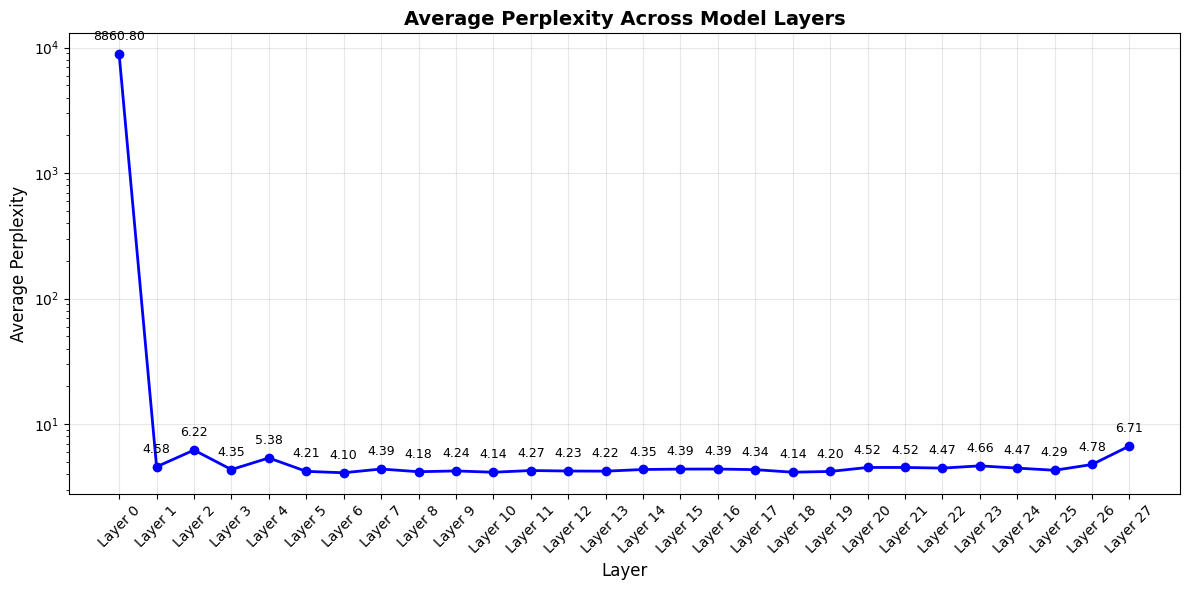

In [73]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_perplexity(data):
#     """
#     Plot average perplexity across layers
    
#     Args:
#         data: Dictionary with format {'layer0': [perplexities], 'layer1': [perplexities], ...}
#     """
#     # Extract layer names and calculate average perplexities
#     layers = []
#     avg_perplexities = []
#     std_perplexities = []
    
#     # Sort layers by layer number for proper ordering
#     sorted_layers = sorted(data.keys(), key=lambda x: int(x.replace('layer', '')))
    
#     for layer in sorted_layers:
#         layers.append(layer)
#         perplexities = data[layer]
#         avg_perplexities.append(np.mean(perplexities))
#         std_perplexities.append(np.std(perplexities))
    
#     # Create the plot
#     plt.figure(figsize=(12, 6))
    
#     # Plot line with error bars (optional)
#     x_positions = range(len(layers))
#     plt.plot(x_positions, avg_perplexities, 'b-o', linewidth=2, markersize=6)
# #     plt.fill_between(x_positions, 
# #                      np.array(avg_perplexities) - np.array(std_perplexities),
# #                      np.array(avg_perplexities) + np.array(std_perplexities),
# #                      alpha=0.3, color='blue')
    
#     # Customize the plot
#     plt.xlabel('Layer', fontsize=12)
#     plt.ylabel('Average Perplexity', fontsize=12)
#     plt.title('Average Perplexity Across Model Layers', fontsize=14, fontweight='bold')
#     plt.grid(True, alpha=0.3)
    
#     # Set x-axis labels
#     plt.xticks(x_positions, [f'Layer {i}' for i in range(len(layers))], rotation=45)
    
#     # Add value labels on points (optional)
#     for i, (x, y) in enumerate(zip(x_positions, avg_perplexities)):
#         plt.annotate(f'{y:.2f}', (x, y), textcoords="offset points", 
#                     xytext=(0,10), ha='center', fontsize=9)
    
#     plt.yscale('log')
#     plt.tight_layout()
#     plt.show()


# plot_perplexity(ppl)

/tmpdata/ipykernel_4020268/3280641907.py:33: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(x_positions, avg_perplexities, 'b-o', linewidth=2, markersize=6, color='blue')
/tmpdata/ipykernel_4020268/3280641907.py:43: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-o" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(x_positions, avg_cosines, 'r-o', linewidth=2, markersize=6, color='red')
/tmpdata/ipykernel_4020268/3280641907.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax3.plot(x_positions, avg_diff_input_cosines, 'g-o', linewidth=2, markersize=6, color='green')


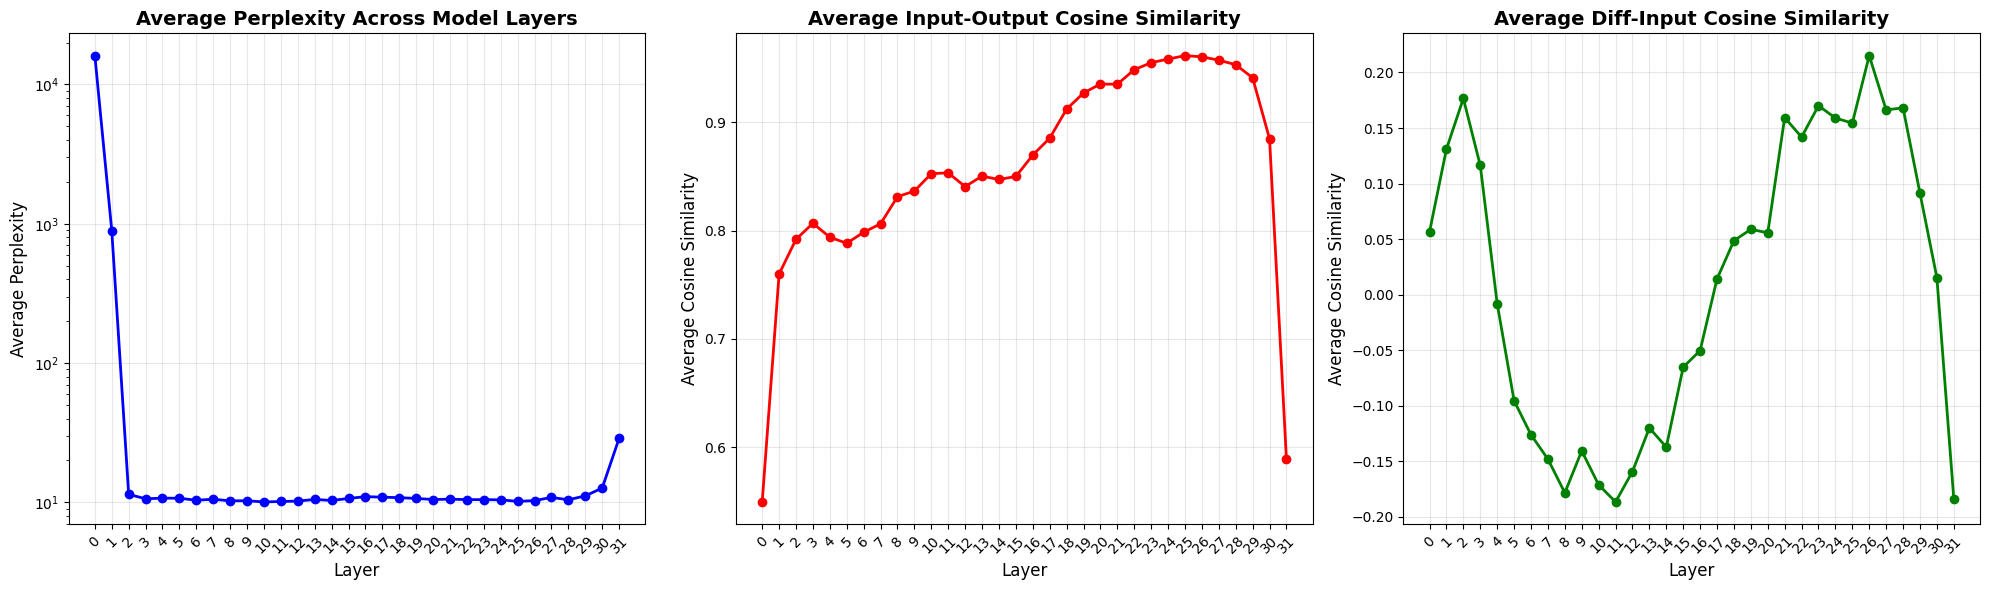

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_perplexity_and_cosine(ppl_data, cosine_data, diff_input_cosine_data):
    """
    Plot average perplexity and cosine similarities across layers in subplots
    
    Args:
        ppl_data: Dictionary with format {'layer0': [perplexities], 'layer1': [perplexities], ...}
        cosine_data: Dictionary with format {'layer0': [cosine_similarities], 'layer1': [cosine_similarities], ...}
        diff_input_cosine_data: Dictionary with format {'layer0': [diff_input_cosines], 'layer1': [diff_input_cosines], ...}
    """
    # Extract layer names and calculate averages for all metrics
    layers = []
    avg_perplexities = []
    avg_cosines = []
    avg_diff_input_cosines = []
    
    # Sort layers by layer number for proper ordering
    sorted_layers = sorted(ppl_data.keys(), key=lambda x: int(x.replace('layer', '')))
    
    for layer in sorted_layers:
        layers.append(layer)
        avg_perplexities.append(np.mean(ppl_data[layer]))
        avg_cosines.append(np.mean(cosine_data[layer]))
        avg_diff_input_cosines.append(np.mean(diff_input_cosine_data[layer]))
    
    # Create subplots with 1 row, 3 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    x_positions = range(len(layers))
    
    # Plot perplexity on the left
    ax1.plot(x_positions, avg_perplexities, 'b-o', linewidth=2, markersize=6, color='blue')
    ax1.set_xlabel('Layer', fontsize=12)
    ax1.set_ylabel('Average Perplexity', fontsize=12)
    ax1.set_title('Average Perplexity Across Model Layers', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    ax1.set_yscale('log')
    
    # Plot input-output cosine similarity in the middle
    ax2.plot(x_positions, avg_cosines, 'r-o', linewidth=2, markersize=6, color='red')
    ax2.set_xlabel('Layer', fontsize=12)
    ax2.set_ylabel('Average Cosine Similarity', fontsize=12)
    ax2.set_title('Average Input-Output Cosine Similarity', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    
    # Plot difference-input cosine similarity on the right
    ax3.plot(x_positions, avg_diff_input_cosines, 'g-o', linewidth=2, markersize=6, color='green')
    ax3.set_xlabel('Layer', fontsize=12)
    ax3.set_ylabel('Average Cosine Similarity', fontsize=12)
    ax3.set_title('Average Diff-Input Cosine Similarity', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(x_positions)
    ax3.set_xticklabels([f'{i}' for i in range(len(layers))], rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage example:
plot_perplexity_and_cosine(ppl, cosines, diff_input_cosines)

In [12]:
def analyze_norms(llm, prompts):
    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:
            att_cos_all = 0
            mlp_cos_all = 0
            layer_cos_all = 0

            mean_relative_contribution_att = 0
            mean_relative_contribution_mlp = 0
            mean_relative_contribution_layer = 0

            cnt = 0

            for i, prompt in enumerate(prompts):
                with llm.trace(prompt):
                    att_cos = []
                    mlp_cos = []
                    layer_cos = []
                    relative_contribution_att = []
                    relative_contribution_mlp = []
                    relative_contribution_layer = []

                    for i, layer in enumerate(llm.model.layers):
                        # Relative contribution of the attention to the residual stream.

                        layer_inputs = layer.inputs[0][0]
                        self_attn_output = layer.self_attn.output[0]

                        relative_contribution_att.append(
                            (self_attn_output.detach().norm(dim=-1).float() / layer_inputs.detach().norm(dim=-1).float().clamp(min=1e-6)).sum(1).cpu()
                        )

                        # Relative contribution of the MLP to the residual stream. The corresponding
                        # accumulation point is after the self-attention.
                        mlp_input = (self_attn_output + layer_inputs).detach()
                        mlp_output = layer.mlp.output
                        relative_contribution_mlp.append(
                            (mlp_output.detach().norm(dim=-1).float() / mlp_input.norm(dim=-1).clamp(min=1e-6).float()).sum(1).cpu()
                        )

                        # Relative contribution of the layer to the residual stream.
                        layer_output = layer.output[0]
                        layer_diff = (layer_output - layer_inputs).detach()
                        relative_contribution_layer.append(
                            (layer_diff.norm(dim=-1).float() / layer_inputs.detach().norm(dim=-1).float().clamp(min=1e-6)).sum(1).cpu()
                        )

                        # Cosine similarities between the same points as the relative contributions above.
                        att_cos.append(F.cosine_similarity(self_attn_output.detach(), layer_inputs.detach(), dim=-1).sum(1).cpu().float())
                        mlp_cos.append(F.cosine_similarity(mlp_output.detach(), mlp_input, dim=-1).sum(1).cpu().float())
                        layer_cos.append(F.cosine_similarity(layer_diff, layer_inputs.detach(), dim=-1).sum(1).cpu().float())

                        if i == 0:
                            cnt += layer_output.shape[1]

                    mean_relative_contribution_att += torch.cat(relative_contribution_att, dim=0)
                    mean_relative_contribution_mlp += torch.cat(relative_contribution_mlp, dim=0)
                    mean_relative_contribution_layer += torch.cat(relative_contribution_layer, dim=0)

                    att_cos_all += torch.cat(att_cos, dim=0)
                    mlp_cos_all += torch.cat(mlp_cos, dim=0)
                    layer_cos_all += torch.cat(layer_cos, dim=0)

            att_cos_all = (att_cos_all / cnt).save()
            mlp_cos_all = (mlp_cos_all / cnt).save()
            layer_cos_all = (layer_cos_all / cnt).save()

            mean_relative_contribution_att = (mean_relative_contribution_att / cnt).save()
            mean_relative_contribution_mlp = (mean_relative_contribution_mlp / cnt).save()
            mean_relative_contribution_layer = (mean_relative_contribution_layer / cnt).save()

    return (mean_relative_contribution_att, mean_relative_contribution_mlp, mean_relative_contribution_layer,
            att_cos_all, mlp_cos_all, layer_cos_all)

In [13]:
import numpy as np

In [14]:
# prompts = np.load('qwen1.5_true_false_gsm8k.npy', allow_pickle=True).tolist()

In [15]:
rc_att, rc_mlp, rc_layer, att_cos, mlp_cos, layer_cos = analyze_norms(llm, prompts)

/scratch/ss13750/conda-envs/nnsight/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:186: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [16]:
def sort_zorder(bars):
    for group in zip(*[container for container in bars]):
        # 'group' is a tuple of bar objects at one x position from different groups.
        z = len(group)
        # Sort the bars by height (lowest first).
        for bar in sorted(group, key=lambda b: abs(b.get_height())):
            bar.set_zorder(z)
            z -= 1

In [17]:
def plot_residual_stats(att, mlp, layer):
    plt.figure(figsize=(6,3))
    bars = []
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], att.float().cpu().numpy(), label="Attention", width=1.1))
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], mlp.float().cpu().numpy(), label="MLP", width=1.1))
    bars.append(plt.bar([x for x in range(len(llm.model.layers))], layer.float().cpu().numpy(), label="Attention + MLP", width=1.1))
    plt.legend()
    sort_zorder(bars)
    plt.xlim(-0.5, len(llm.model.layers)-0.5)
    plt.xlabel("Layer index ($l$)")

In [18]:
rc_layer

tensor([2.8619, 0.2247, 0.0942, 0.0816, 0.0807, 0.0691, 0.0753, 0.0722, 0.0676,
        0.0666, 0.0647, 0.0667, 0.0586, 0.0577, 0.0554, 0.0547, 0.0558, 0.0607,
        0.0652, 0.0756, 0.0712, 0.0789, 0.0799, 0.0696, 0.0723, 0.0570, 0.0611,
        0.1079])

Text(0, 0.5, 'Mean Relative Contribution')

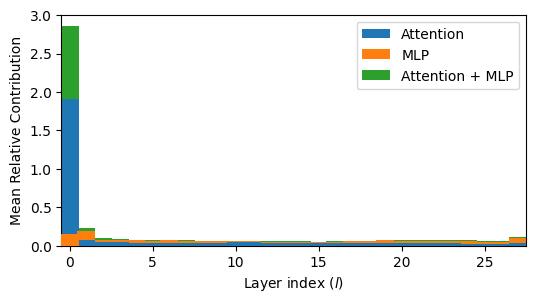

In [19]:
plot_residual_stats(rc_att, rc_mlp, rc_layer)
# plt.ylim(0, 0.1)
plt.ylabel("Mean Relative Contribution")

Text(0, 0.5, 'Cosine similarity')

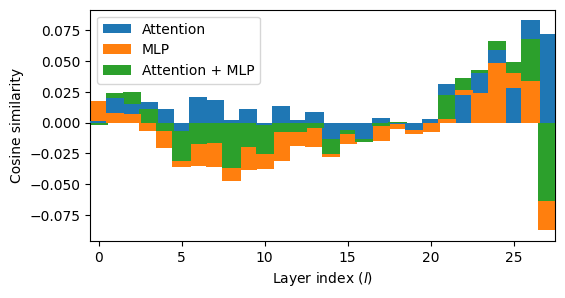

In [20]:
plot_residual_stats(att_cos, mlp_cos, layer_cos)
plt.ylabel("Cosine similarity")

In [50]:
def merge_io(intervened: torch.Tensor, orig: torch.Tensor, t: Optional[int] = None, no_skip_front: int = 1) -> torch.Tensor:
    # Merge intervened and original inputs. If t is not None, keep the intervened input until t, otherwise keep it everywhere.
    # It does not intervene on the first no_skip_front tokens.
#     return intervened[:, :].to(orig.device)
    outs = [orig[:, :no_skip_front]]
    if t is not None:
        outs.append(intervened[:, no_skip_front:t].to(orig.device))
        outs.append(orig[:, t:])
    else:
        outs.append(intervened[:, no_skip_front:].to(orig.device))

    return torch.cat(outs, dim=1)


def get_future(data: torch.Tensor, t: Optional[int]) -> torch.Tensor:
    # Get future tokens from position t onwards. If t is None, return all tokens.
    if t is not None:
        return data[:, t:]
    else:
        return data


def test_effect(llm: LanguageModel, prompt: str, positions: List[Optional[int]], no_skip_front: int = 1) -> tuple[torch.Tensor, torch.Tensor]:
    # Test effect of skipping a layer on all future layers and the output probabilities.
    # If multiple positions are provided, the maximum is taken over all positions.
    # If position is None, it measures the effect on all tokens, not just the future.
    # Note: Detach must be explicitly called on each saved tensor, ortherwise the graph will be kept and it will run out of memory.
    # This is despite being wrapped in torch.no_grad().


    # The idea is to run all interventions in a single session to avoid downloading intermediate activations,
    # which can be very large. The output of matmul in bfloat16 is sensitive to the kernel used by cuBLAS,
    # which changes with the batch size. So run everything in a single batch.

    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:

            dall = torch.zeros(1)
            dall_out = torch.zeros(1)

            residual_log = []

            # Run the model to get the original residuals and output probabilities.
            with llm.trace(prompt) as tracer:
                for i, layer in enumerate(llm.model.layers):
                    if i == 0:
                        residual_log.clear()
                    inp = layer.inputs[0][0].detach().cpu().float()
                    out = layer.output[0].detach().cpu().float()
                    residual_log.append(out - inp)

                residual_log = torch.cat(residual_log, dim=0)
                outputs = llm.output.logits.detach().float().softmax(dim=-1).cpu()

            # Do intervention on each position.
            for t in positions:
                diffs = []
                out_diffs = []

                # Do intervention on each layer.
                for lskip in range(len(llm.model.layers)):
                    with llm.trace(prompt) as tracer:
                        new_logs = []

                        # Log all the layer outputs.
                        for i, layer in enumerate(llm.model.layers):
                            
                            layer_inputs = layer.inputs[0][0]
                            # skip the layer
                            if i == lskip:
                                #if lskip == len(llm.model.layers) - 1: contu
                                layer_output = layer.output
                                #print(lskip, i, layer_inputs.shape, layer_output.shape)
                                layer.output = (merge_io(layer_inputs, layer_output, t, no_skip_front))

                            new_logs.append((layer.output[0].detach().cpu().float() - layer_inputs.detach().cpu().float()))

                        new_logs = torch.cat(new_logs, dim=0).float()

                        # Measure the relative difference of the residuals on the future tokens
                        relative_diffs = (get_future(residual_log, t) - get_future(new_logs, t)).norm(dim=-1) / get_future(residual_log, t).norm(dim=-1).clamp(min=1e-6)

                        # Take the max realtive difference over the sequence lenght
                        diffs.append(relative_diffs.max(dim=-1).values)

                        # Measure the max relative difference of the output probabilities on the future tokens
                        out_diffs.append((get_future(llm.output.logits.detach(), t).float().softmax(dim=-1).cpu() - get_future(outputs, t)).norm(dim=-1).max(dim=-1).values)

                # Concatenate effects over all layers.
                dall = torch.max(dall, torch.stack(diffs, dim=0))
                dall_out = torch.max(dall_out, torch.stack(out_diffs, dim=0))

            dall = dall.save()
            dall_out = dall_out.save()
    return dall, dall_out

In [42]:
def merge_io(intervened: torch.Tensor, orig: torch.Tensor, t: Optional[int] = None, no_skip_front: int = 1) -> torch.Tensor:
    # Merge intervened and original inputs. If t is not None, keep the intervened input until t, otherwise keep it everywhere.
    # It does not intervene on the first no_skip_front tokens.
    outs = [orig[:, :no_skip_front]]
    if t is not None:
        outs.append(intervened[:, no_skip_front:t].to(orig.device))
        outs.append(orig[:, t:])
    else:
        outs.append(intervened[:, no_skip_front:].to(orig.device))

    return torch.cat(outs, dim=1)


def get_future(data: torch.Tensor, t: Optional[int]) -> torch.Tensor:
    # Get future tokens from position t onwards. If t is None, return all tokens.
    if t is not None:
        return data[:, t:]
    else:
        return data


def test_effect(llm: LanguageModel, prompt: str, positions: List[Optional[int]], no_skip_front: int = 1) -> tuple[torch.Tensor, torch.Tensor]:
    # Test effect of skipping a layer on all future layers and the output probabilities.
    # If multiple positions are provided, the maximum is taken over all positions.
    # If position is None, it measures the effect on all tokens, not just the future.
    # Note: Detach must be explicitly called on each saved tensor, ortherwise the graph will be kept and it will run out of memory.
    # This is despite being wrapped in torch.no_grad().


    # The idea is to run all interventions in a single session to avoid downloading intermediate activations,
    # which can be very large. The output of matmul in bfloat16 is sensitive to the kernel used by cuBLAS,
    # which changes with the batch size. So run everything in a single batch.

    with torch.no_grad():
        with llm.session(remote=REMOTE) as session:

            dall = torch.zeros(1)
            dall_out = torch.zeros(1)

            residual_log = []

            # Run the model to get the original residuals and output probabilities.
            with llm.trace(prompt) as tracer:
                for i, layer in enumerate(llm.model.layers):
                    if i == 0:
                        residual_log.clear()
                    inp = layer.inputs[0][0].detach().cpu().float()
                    out = layer.output[0].detach().cpu().float()
                    residual_log.append(out - inp)

                residual_log = torch.cat(residual_log, dim=0)
                outputs = llm.output.logits.detach().float().softmax(dim=-1).cpu()

            # Do intervention on each position.
            for t in positions:
                diffs = []
                out_diffs = []

                # Do intervention on each layer.
                for lskip in range(len(llm.model.layers)):
                    with llm.trace(prompt) as tracer:
                        new_logs = []

                        # Log all the layer outputs.
                        for i, layer in enumerate(llm.model.layers):

                            layer_inputs = layer.inputs[0][0]
                            # skip the layer
                            if i == lskip:

                                layer_output = layer.output[0]
                                layer.output = (merge_io(layer_inputs, layer_output, t, no_skip_front))

                            new_logs.append((layer.output[0].detach().cpu().float() - layer_inputs.detach().cpu().float()))

                        new_logs = torch.cat(new_logs, dim=0).float()

                        # Measure the relative difference of the residuals on the future tokens
                        relative_diffs = (get_future(residual_log, t) - get_future(new_logs, t)).norm(dim=-1) / get_future(residual_log, t).norm(dim=-1).clamp(min=1e-6)

                        # Take the max realtive difference over the sequence lenght
                        diffs.append(relative_diffs.max(dim=-1).values)

                        # Measure the max relative difference of the output probabilities on the future tokens
                        out_diffs.append((get_future(llm.output.logits.detach(), t).float().softmax(dim=-1).cpu() - get_future(outputs, t)).norm(dim=-1).max(dim=-1).values)

                # Concatenate effects over all layers.
                dall = torch.max(dall, torch.stack(diffs, dim=0))
                dall_out = torch.max(dall_out, torch.stack(out_diffs, dim=0))

            dall = dall.save()
            dall_out = dall_out.save()
    return dall, dall_out

In [51]:
def plot_layer_diffs(dall: torch.Tensor) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(10,3))
    im = ax.imshow(dall.float().cpu().numpy(), vmin=0, vmax=1, interpolation="nearest")
    plt.ylabel("Layer skipped")
    plt.xlabel("Effect @ layer")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.2, pad=0.1)
    cbar = fig.colorbar(im, cax=cax, label='Relative change')
    return fig


def plot_logit_diffs(dall: torch.Tensor) -> plt.Figure:
    fig = plt.figure(figsize=(6,3))
    dall = dall.squeeze()
    plt.bar(list(range(dall.shape[0])), dall)
    plt.xlim(-1, dall.shape[0])
    plt.xlabel("Layer")
    plt.ylabel("Output change norm")
    return fig

In [52]:
def plot_effects(llm: LanguageModel, n_examples: int, test_fn):
    random.seed(123)

    max_future_layer = torch.zeros([1])
    max_future_out = torch.zeros([1])
    for idx, prompt in enumerate(GSM8K()):
        diff_now, diff_out = test_fn(llm, prompt)
#         print(diff_now)
        max_future_layer = torch.max(max_future_layer, diff_now)
        max_future_out = torch.max(max_future_out, diff_out)

        if idx == n_examples - 1:
            break

    plot_layer_diffs(max_future_layer)
    plot_logit_diffs(max_future_out)

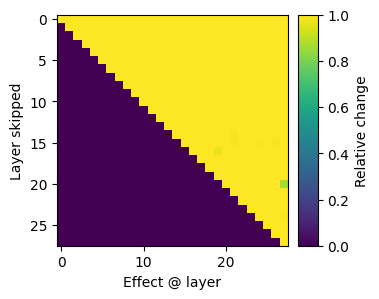

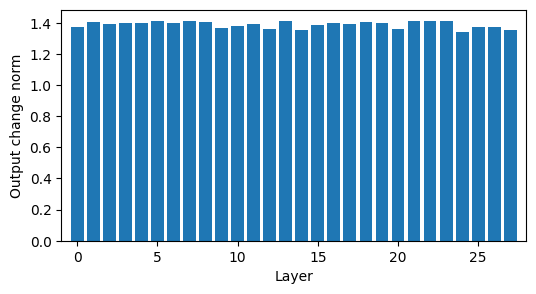

In [53]:
def test_all_max_effect(llm: LanguageModel, prompt: str, N_CHUNKS: int = 4):
    return test_effect(llm, prompt, [None])

plot_effects(llm, N_EXAMPLES, test_all_max_effect)

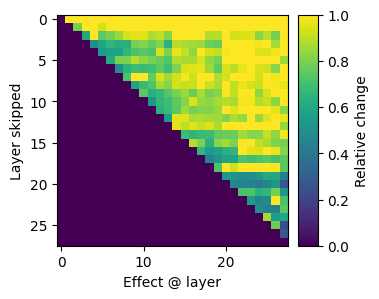

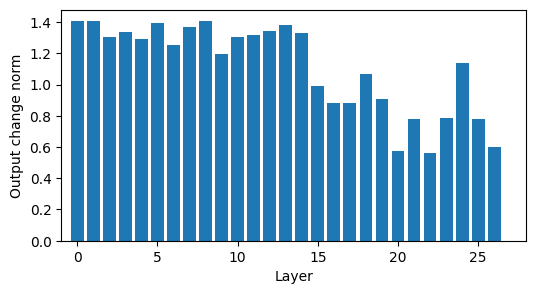

In [54]:
def test_future_max_effect(llm: LanguageModel, prompt: str, N_CHUNKS: int = 4):
    # Sample N_CHUNKS positions to intervene on and calculate the maximum effect on this single prompt.
    tokens = tokenize(llm, prompt)
    
    positions = list(range(8, len(tokens)-4, 8))
    random.shuffle(positions)
    positions = positions[:N_CHUNKS]

    return test_effect(llm, prompt, positions)

plot_effects(llm, N_EXAMPLES, test_future_max_effect)

In [55]:
N_EXAMPLES

10